In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Transfer Learning 을 통한 Cats and Dogs 데이터 셋 분류 성능(속도) 개선
* VGG16 Backbone을 통한 feature extract 과정 중복 수행 제거

### Step 1. Input tensor 와 Target tensor 준비(훈련데이터)

(1) Cats and Dogs 데이터셋 다운로드

In [ ]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True,
                                   cache_dir='/content')

68608000/68606236 [==============================] - 0s 0us/step


(2) ImageDataGenerator를 이용해 이미지 파일을 load 하기 위한 경로 지정

In [ ]:
train_dir = '/content/datasets/cats_and_dogs_filtered/train'
validation_dir = '/content/datasets/cats_and_dogs_filtered/validation'

(3) ImageDataGenerator 객체 생성  
* 객체 생성 시 rescale 인자를 이용하여 텐서 내 원소의 범위를 [0 ~ 255] => [0 ~ 1] 로 ReScaling 진행

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

* .flow_from_directory() 메서드를 이용하여 학습데이터와 검증데이터를 위한 DirectoryIterator 객체 생성

In [ ]:
batch_size = 32
width = 224
height = 224

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(width, height),
        batch_size=batch_size,
        shuffle=True,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(width, height),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Step 2. VGG16 Backbone을 통해 feature map 정보 추출

(1) Pre-trained 된 VGG16 모델 객체 생성
  * imagenet 데이터를 이용해 학습된 모델 객체 생성
  * classification layer 제외

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
conv_base = VGG16(include_top=False,
                  input_shape=(width, height, 3),
                  weights='imagenet')

(2) VGG16 Backbone을 통해 feature extract 을 수행하는 함수 생성


In [ ]:
train_generator.samples

2000

In [ ]:
def extract_features(generator, backbone):
  # 0 값으로 채워져 있는 features, labels ndarray 객체 생성
  # features.shape => (sample, 7, 7, 512)
  features = np.zeros(shape=(generator.samples, 7, 7 , 512))
  # labels.shape => (sample, )
  labels = np.zeros(shape=(generator.samples, ))

  i = 0

  # inputs_batch.shape => (32, 224, 224, 3)
  # labels_batch.shape => (32, )
  for input_batch, labels_batch in tqdm(generator):
    if i >= len(generator):
      break
    
    # backbone 모델(backbones) 을 이용해 feature map을 얻음
    # features_batch.shape => (32, 7, 7, 512)
    features_batch = backbone(input_batch)

    # featue map을 features에 업데이트
    if i < len(generator)-1:
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch 
    else:
        features[i * batch_size : ] = features_batch
        labels[i * batch_size : ] = labels_batch
    i += 1

  return features, labels

(3) extract_features 함수를 이용하여 이미지에서 Backbone 모델을 이용해 feature map 정보 추출


In [ ]:
train_generator.reset()
validation_generator.reset()

In [ ]:
train_features, train_labels = extract_features(train_generator, conv_base)
validation_features, validation_labels = extract_features(validation_generator, conv_base)

In [ ]:
train_features.shape, validation_features.shape

((2000, 7, 7, 512), (1000, 7, 7, 512))

### Step 3. classification 만을 위한 DNN(MLP) 모델 생성

In [ ]:
input = keras.Input(shape=(7, 7, 512))

x = keras.layers.Flatten()(input)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

In [ ]:
model = keras.Model(
    inputs=input,
    outputs=output
)

### Step 4. 모델의 학습 정보 설정

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

### Step 5. 모델에 데이터 연결 후 학습 
  * model.fit() 이용하여 데이터 연결 및 학습시키기
  * 학습 과정은 history 변수에 저장

In [ ]:
history = model.fit(x=train_features, y=train_labels,
                    epochs=10,
                    validation_data=(validation_features, validation_labels))

Epoch 1/10
63/63 [==============================] - 1s 9ms/step - loss: 0.5567 - accuracy: 0.7100 - val_loss: 0.3769 - val_accuracy: 0.8650
Epoch 2/10
63/63 [==============================] - 0s 7ms/step - loss: 0.3638 - accuracy: 0.8405 - val_loss: 0.3026 - val_accuracy: 0.8830
Epoch 3/10
63/63 [==============================] - 0s 7ms/step - loss: 0.2971 - accuracy: 0.8770 - val_loss: 0.2731 - val_accuracy: 0.8940
Epoch 4/10
63/63 [==============================] - 0s 7ms/step - loss: 0.2436 - accuracy: 0.9025 - val_loss: 0.2648 - val_accuracy: 0.8910
Epoch 5/10
63/63 [==============================] - 0s 7ms/step - loss: 0.2095 - accuracy: 0.9220 - val_loss: 0.2417 - val_accuracy: 0.8980
Epoch 6/10
63/63 [==============================] - 0s 7ms/step - loss: 0.1764 - accuracy: 0.9355 - val_loss: 0.2328 - val_accuracy: 0.9010
Epoch 7/10
63/63 [==============================] - 0s 6ms/step - loss: 0.1599 - accuracy: 0.9445 - val_loss: 0.2830 - val_accuracy: 0.8730
Epoch 8/10
63/63 [==

### Step 6. 학습 과정 시각화

(1) history 객체를 전달받아 학습 과정을 시각화 할 수 있는 history_chart 함수 정의

In [ ]:
def history_chart(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

(2) history_chart 함수를 이용하여 학습 과정 시각화

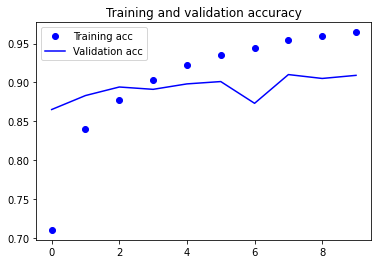

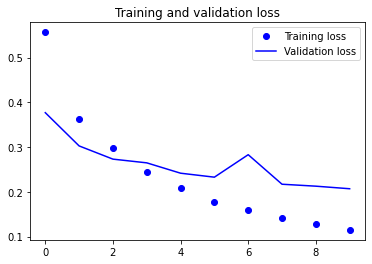

In [ ]:
history_chart(history)

### Step 7. 테스트 데이터 셋을 통한 모델의 성능 평가

In [ ]:
test_loss, test_accuracy = model.evaluate(validation_features, validation_labels)

32/32 [==============================] - 0s 3ms/step - loss: 0.2069 - accuracy: 0.9090


In [ ]:
print(type(conv_base.layers[0]))
print(type(conv_base.layers[0].input))
print(type(conv_base.layers[0].output))

<class 'tensorflow.python.keras.engine.input_layer.InputLayer'>
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>


In [ ]:
tmp_model = keras.Model(
    inputs=conv_base.input,
    outputs=conv_base.layers[-2].output
)

In [ ]:
tmp_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 앙상블 기법을 이용한 Transfer Learning model의 Cats and Dogs 데이터 셋 분류 성능 개선
* 여러 Backbone의 앙상블 기법

### Step 1. Input tensor 와 Target tensor 준비(훈련데이터)

(3) ImageDataGenerator 객체 생성  
* 인셉션 계열 backbone 들을 위해 Rescailing 진행안함

In [ ]:
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

* .flow_from_directory() 메서드를 이용하여 학습데이터와 검증데이터를 위한 DirectoryIterator 객체 생성

In [ ]:
batch_size = 32
width = 299
height = 299

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(width, height),
        batch_size=batch_size,
        shuffle=True,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(width, height),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Step 2.Backbone 모델들을 통해 feature extract 된 값 생성

(1) 여러개의 Backbone 모델들에서 추출한 feature 정보를을 concatenate 시켜 반환하는 함수 정의


In [ ]:
inceptionV3_backbone = keras.applications.InceptionV3(include_top=False,
                                                      input_shape=(width, height, 3),
                                                      weights='imagenet')
xception_backbone = keras.applications.Xception(include_top=False,
                                                input_shape=(width, height, 3),
                                                weights='imagenet')

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
# 2개의 backbone 모델(backbones) 을 이용해 2개의 feature map을 얻고
# 해당 정보를 결합하는 앙상블 모델 설계
input = keras.Input(shape=(width, height, 3))

feature_a = keras.applications.inception_v3.preprocess_input(input)
# feature_a.shape => (None, 8, 8, 2048)
feature_a = inceptionV3_backbone(feature_a)
# feature_a.shape => (None, 2048)
feature_a = keras.layers.GlobalAveragePooling2D()(feature_a)

feature_b = keras.applications.xception.preprocess_input(input)
# feature_b.shape => (None, 10, 10, 2048)
feature_b = xception_backbone(feature_b)
# feature_b.shape => (None, 2048)
feature_b = keras.layers.GlobalAveragePooling2D()(feature_b)

# output.shape => (None, 4096(2048+2048))
output = keras.layers.Concatenate()([feature_a, feature_b])

model = keras.Model(
    inputs=input,
    outputs=output
)

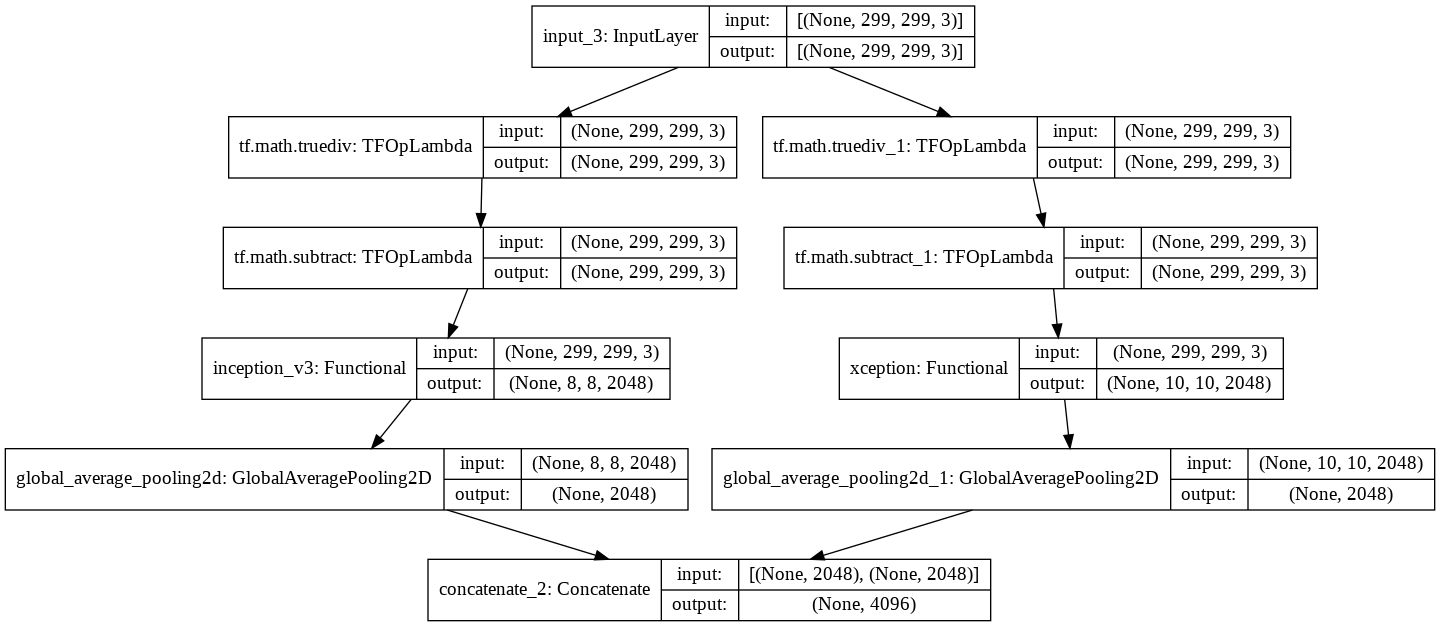

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
def extract_features(model, generator):
  # 0 값으로 채워져 있는 features, labels ndarray 객체 생성
  # features.shape => (sample, 4096)
  features = np.zeros(shape=(generator.samples, 4096))
  # labels.shape => (sample, )
  labels = np.zeros(shape=(generator.samples, ))

  i = 0

  # inputs_batch.shape => (32, 299, 299, 3)
  # labels_batch.shape => (32, )
  for input_batch, labels_batch in tqdm(generator):
    if i >= len(generator):
      break
    
    # features_batch.shape => (32, 4096)
    features_batch = model(input_batch)

    # featue map을 features에 업데이트
    if i < len(generator)-1:
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch 
    else:
        features[i * batch_size : ] = features_batch
        labels[i * batch_size : ] = labels_batch
    i += 1
  return features, labels

(3) extract_features() 함수를 이용하여 추출된 피쳐값 생성

In [ ]:
train_generator.reset()
validation_generator.reset()

In [ ]:
train_features, train_labels = extract_features(model, train_generator)
validation_features, validation_labels = extract_features(model, validation_generator)

In [ ]:
train_features.shape, validation_features.shape

((2000, 4096), (1000, 4096))

### Step 3. classification 만을 위한 DNN(MLP) 모델 생성

In [ ]:
input = keras.Input(shape=(model.output_shape[-1], ))

x = keras.layers.Dense(256, 'relu')(input)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, 'sigmoid')(x)

In [ ]:
ensemble_model = keras.Model(
    inputs=input,
    outputs=output
)

In [ ]:
ensemble_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,049,089
Trainable params: 1,049,089
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델의 학습 정보 설정

In [ ]:
ensemble_model.compile(loss='binary_crossentropy',
                        optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                        metrics=['accuracy'])

### Step 5. 모델에 데이터 연결 후 학습 
  * model.fit() 이용하여 데이터 연결 및 학습시키기
  * 학습 과정은 history 변수에 저장

In [ ]:
history = ensemble_model.fit(
      x=train_features, y=train_labels,
      epochs=10,
      batch_size=32,
      validation_data=(validation_features, validation_labels))

Epoch 1/10
63/63 [==============================] - 1s 7ms/step - loss: 0.3672 - accuracy: 0.9005 - val_loss: 0.1773 - val_accuracy: 0.9900
Epoch 2/10
63/63 [==============================] - 0s 4ms/step - loss: 0.1309 - accuracy: 0.9825 - val_loss: 0.0739 - val_accuracy: 0.9930
Epoch 3/10
63/63 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 0.9900 - val_loss: 0.0435 - val_accuracy: 0.9930
Epoch 4/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0450 - accuracy: 0.9895 - val_loss: 0.0317 - val_accuracy: 0.9940
Epoch 5/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0347 - accuracy: 0.9915 - val_loss: 0.0264 - val_accuracy: 0.9940
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0290 - accuracy: 0.9955 - val_loss: 0.0221 - val_accuracy: 0.9950
Epoch 7/10
63/63 [==============================] - 0s 4ms/step - loss: 0.0239 - accuracy: 0.9945 - val_loss: 0.0210 - val_accuracy: 0.9940
Epoch 8/10
63/63 [==

### Step 6. 학습 과정 시각화

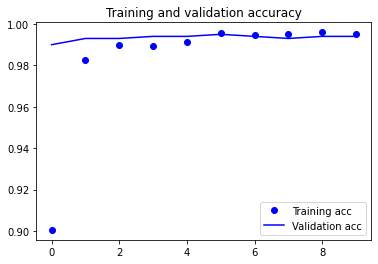

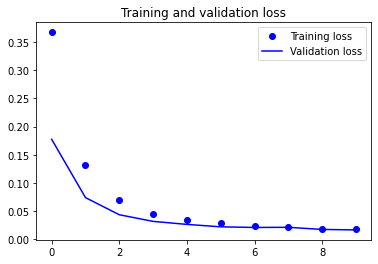

In [ ]:
history_chart(history)

### Step 7. 테스트 데이터 셋을 통한 모델의 성능 평가

In [ ]:
test_loss, test_accuracy = ensemble_model.evaluate(validation_features, validation_labels)

32/32 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 0.9940
